**Sequential Training of Mass-Constrained Radial Basis Function (McRBF) Networks with Probabilistic Center Distribution**

This code demonstrates the sequential training algorithms for Mass-Constrained RBF network models using the Constrained Least Squares (CLS) approach where linear mass constraints are imposed on the model outputs to ensure exact conservation of mass. The training of the unconstrained RBF model fixes the network structure. RBF network models with probabilistic distribution of centers are considered for demonstration.

While the *Rigorous approach* developed for training unconstrained RBF models will still require the linear constraint equations to be augmented as additional constraints during the parameter estimation problem, both the *Approximate approach* for standalone RBF networks as well as the sequential training algorithms for the hybrid GRAB-NN models can take sufficient advantage of the CLS approach to ensure exact satisfaction of the imposed constraints during parameter estimation. The training approaches proposed here can readily be augmented / coupled with the structural optimization of RBF / GRAB-NN models using the MINLP algorithms developed in this work.

The approximate approach is considered here for demonstrating the training of McRBF models. 

*Load the training and validation datasets and specify the input and output variables for the RBF models. Note that the user can consider any dynamic dataset for training and validation. The rows signify the time steps for transient data and the columns signify the input and output variables.*

*The nonlinear steady-state continuous stirred tank reactor (CSTR) system is chosen for demonstration of the proposed approach.*

In [1]:
import numpy as np
import scipy as sp
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from idaes.core.solvers import get_solver
get_solver()
import matplotlib.pyplot as plt
import pandas as pd
from pyDOE import *
import math as mt
import time
import json
import pickle

In [2]:
# Loading the (true) data of the system under consideration

# The true data are simulated from a first-principles model of the CSTR under consideration. However, the true data are not considered in 
# any way during model training. The 'true data' are only used to check whether the outputs from the McRBF model converge at the system truth even
# when trained with noisy measurements which violate the mass balance constraints

data = pd.read_excel("Steady-State CSTR Data.xlsx","True_Data", header=None).values
data = data[2:,1:]

output_data_true = data[:,5:]

In [3]:
# Loading the noisy training (measurement) data of the system under consideration

data = pd.read_excel("Steady-State CSTR Data.xlsx","Noisy_Data", header=None).values
data = data[2:,1:]

input_data = data[:,0:5]
output_data = data[:,5:]

In [4]:
# Specification of Model Inputs and Target Outputs

data = np.concatenate((input_data, output_data), axis = 1)
ni = input_data.shape[1]
no = output_data.shape[1]
nt = ni+no

tt = data.shape[0]
tn = int(np.floor(0.7*tt))

# Normalizing the input and output variables

norm_mat = np.zeros((tt,nt))
delta = np.zeros((1,nt))
for i in range(nt):
    delta[:,i] = max(data[:,i]) - min(data[:,i])
    norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]

Imat = norm_mat[:,0:ni]; Imat = Imat.transpose();
dsr = norm_mat[:,ni:ni+no]; dsr = dsr.transpose();

# TRAINING OF RBFNN

tr_steps = np.random.choice(tt, tn, replace=False)
# tr_steps = np.array([1:tn])
tr_steps = np.sort(tr_steps) 

dsr_t = np.zeros((no,tn))
Imat_t = np.zeros((ni,tn))

for i in range(tn):
    ts = tr_steps[i]
    dsr_t[:,i] = dsr[:,ts]
    Imat_t[:,i] = Imat[:,ts]

In [5]:
# Number of centers and coordinates of centers / widths determined by the unconstrained problem

tc = 25  # number of centers (can be optimized using the sequential MINLP approaches)

sigma_arr = np.zeros((ni,1))
# Definining widths for the neurons in hidden layer
for k in range(ni):
    sigma_arr[k] = np.std(Imat_t[k])
    
sigma = 4*np.mean(sigma_arr)

# Definining centers for the neurons in hidden layer
centermat = np.zeros((ni,tc))

for j in range(ni):
    centermat[j,:] = np.random.normal(np.mean(Imat_t[j,:]),0.5*sigma_arr[j],tc)

D = np.zeros((tc,tn))

for i, c in enumerate(centermat.T):
    D[i,:] =  np.linalg.norm(Imat_t.T - c, 2, axis = 1)

PhiofD = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))

phi = PhiofD

In [6]:
# Development of Unconstrained RBF

z_womc = np.dot(np.linalg.pinv(PhiofD.T) , dsr_t.T)

In [7]:
# Development of Mass Constrained RBF

# Atom balance equation: CA + CB + CC + 2CD = CAf + CBf + CCf + 2CDf

Q = np.array([1*delta[0,ni], 1*delta[0,ni+1], 1*delta[0,ni+2], 2*delta[0,ni+3]])

CAf_t = input_data[tr_steps,1]
CBf_t = input_data[tr_steps,2]
CCf_t = input_data[tr_steps,3]
CDf_t = input_data[tr_steps,4]

K = CAf_t + CBf_t + CCf_t + 2*CDf_t - min(data[:,ni]) - min(data[:,ni+1]) - min(data[:,ni+2]) - 2*min(data[:,ni+3])

# Creating the matrix phi*phi.T after vectorizing W_opt
                                                            
Big_phi = np.zeros((tc*no,tn*no))

for i in range(no):
    Big_phi[i*tc:(i+1)*tc,i*tn:(i+1)*tn] = phi

phi_phi_T = np.dot(Big_phi,Big_phi.T)

# Creating BIG Q matrix

Big_Q = np.zeros((tn,(tn*no)))

for i in range(no):
    Big_Q[0:tn,i*tn:(i+1)*tn] = Q[i]*np.eye(tn)

# Creating A matrix for constraint formulation AW = K

A = np.dot(Big_Q,Big_phi.T)

# Creating LHS_matrix

LHS_top_mat = np.hstack((phi_phi_T,A.T))
LHS_bottom_mat = np.hstack((A,np.zeros((A.shape[0],A.shape[0]))))

LHS_mat = np.vstack((LHS_top_mat, LHS_bottom_mat))

y_tar = np.reshape(dsr_t,(tn*no,1))

K_mat = np.zeros((tn,1))
for i in range(tn):
    K_mat[i,0] = K[i]

RHS_mat = np.vstack((np.dot(Big_phi,y_tar),K_mat))

w_sol_all = np.dot(np.linalg.pinv(LHS_mat),RHS_mat)
w_sol = w_sol_all[:tc*no]

In [8]:
# Generate the training / validation results

data = np.concatenate((input_data, output_data), axis = 1)
ni = input_data.shape[1]
no = output_data.shape[1]
nt = ni+no
    
tt = data.shape[0]
    
# Normalizing the input and output variables

norm_mat = np.zeros((tt,nt))
delta = np.zeros((1,nt))
for i in range(nt):
    delta[:,i] = max(data[:,i]) - min(data[:,i])
    norm_mat[:,i] = (data[:,i] - min(data[:,i]))/delta[0,i]

in_norm = norm_mat[:,0:ni]; in_norm = in_norm.transpose();
out_norm = norm_mat[:,ni:ni+no]; out_norm = out_norm.transpose();

dsr_v = out_norm; Imat_v = in_norm;

D = np.zeros((tc,tt))
for i, c in enumerate(centermat.T):
    D[i,:] =  np.linalg.norm(Imat_v.T - c, 2, axis = 1)

yHL = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(D*D)/(2*sigma**2))

w_sol = (np.reshape(w_sol,(no,tc))).T

yRBF = np.dot(yHL.T,w_sol)

yRBF_womc = np.dot(yHL.T,z_womc)

target_data = np.zeros((tt,no))
yRBF_unnorm = np.zeros((tt,no))
yRBF_womc_unnorm = np.zeros((tt,no))

for i in range(no):
    target_data[:,i] = np.transpose(dsr_v[i])*delta[0,ni+i] + min(data[:,ni+i])
    yRBF_unnorm[:,i] = yRBF[:,i]*delta[0,ni+i] + min(data[:,ni+i])
    yRBF_womc_unnorm[:,i] = yRBF_womc[:,i]*delta[0,ni+i] + min(data[:,ni+i])

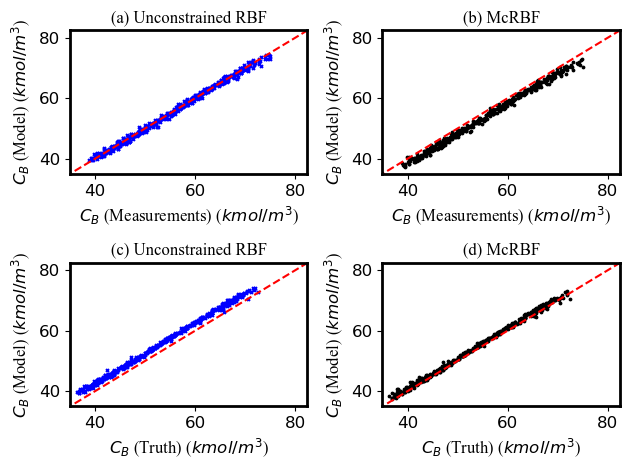

In [9]:
# Plotting Training / Validation Results
true_data = output_data_true

plt.rcParams.update(
    {
        "figure.max_open_warning": 0,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "savefig.bbox": "tight",
        "legend.fontsize": "medium",
    }
)

plt.subplot(2,2,1)
plt.plot(np.linspace(1,2000,2000), np.linspace(1,2000,2000), color = 'red', linewidth = 1.5, linestyle = '--')
plt.scatter(target_data[:,1], yRBF_womc_unnorm[:,1], color = 'blue', marker = 'x', s = 1)
plt.xlim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.ylim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.xlabel('$C_B$ (Measurements) ($kmol/m^3$)', fontname='Times New Roman')
plt.ylabel('$C_B$ (Model) ($kmol/m^3$)', fontname='Times New Roman')
plt.title("(a) Unconstrained RBF", fontname='Times New Roman', fontsize=12)

plt.subplot(2,2,2)
plt.plot(np.linspace(1,2000,2000), np.linspace(1,2000,2000), color = 'red', linewidth = 1.5, linestyle = '--')
plt.scatter(target_data[:,1], yRBF_unnorm[:,1], color = 'black', marker = 'o', s = 3)
plt.xlim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.ylim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.xlabel('$C_B$ (Measurements) ($kmol/m^3$)', fontname='Times New Roman')
plt.ylabel('$C_B$ (Model) ($kmol/m^3$)', fontname='Times New Roman')
plt.title("(b) McRBF", fontname='Times New Roman', fontsize=12)

plt.subplot(2,2,3)
plt.plot(np.linspace(1,2000,2000), np.linspace(1,2000,2000), color = 'red', linewidth = 1.5, linestyle = '--')
plt.scatter(true_data[:,1], yRBF_womc_unnorm[:,1], color = 'blue', marker = 'x', s = 1)
plt.xlim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.ylim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.xlabel('$C_B$ (Truth) ($kmol/m^3$)', fontname='Times New Roman')
plt.ylabel('$C_B$ (Model) ($kmol/m^3$)', fontname='Times New Roman')
plt.title("(c) Unconstrained RBF", fontname='Times New Roman', fontsize=12)

plt.subplot(2,2,4)
plt.plot(np.linspace(1,2000,2000), np.linspace(1,2000,2000), color = 'red', linewidth = 1.5, linestyle = '--')
plt.scatter(true_data[:,1], yRBF_unnorm[:,1], color = 'black', marker = 'o', s = 3)
plt.xlim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.ylim(0.9*min(target_data[:,1]), 1.1*max(target_data[:,1]))
plt.xlabel('$C_B$ (Truth) ($kmol/m^3$)', fontname='Times New Roman')
plt.ylabel('$C_B$ (Model) ($kmol/m^3$)', fontname='Times New Roman')
plt.title("(d) McRBF", fontname='Times New Roman', fontsize=12)

plt.tight_layout()
plt.show()